E-commerce companies generate massive volumes of transactional and customer data but struggle to convert it into actionable insights that improve profitability. Blanket discount strategies often increase short-term sales while silently eroding margins due to poor customer targeting. At the same time, lack of accurate sales forecasting leads to inventory inefficiencies and missed revenue opportunities. The business requires a data-driven system that segments customers intelligently, predicts future demand, and evaluates the true return on discount campaigns. This project builds an end-to-end analytics solution to support strategic marketing, pricing, and inventory decisions.

In [1]:
!pip install flask statsmodels scikit-learn seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.arima.model import ARIMA

from flask import Flask, jsonify
import warnings
warnings.filterwarnings("ignore")


In [3]:
np.random.seed(42)

# Customers
customers = pd.DataFrame({
    "customer_id": range(1, 1501),
    "age": np.random.randint(18, 65, 1500),
    "region": np.random.choice(
        ["North", "South", "East", "West", "Central"], 1500
    ),
    "signup_channel": np.random.choice(
        ["Organic", "Ads", "Referral", "Social Media"], 1500
    )
})

# Orders
orders = pd.DataFrame({
    "order_id": range(1, 20001),
    "customer_id": np.random.choice(customers["customer_id"], 20000),
    "order_date": pd.date_range("2023-01-01", periods=20000, freq="H"),
    "order_value": np.random.gamma(shape=2.2, scale=450, size=20000),
    "discount_applied": np.random.choice([0,1], 20000, p=[0.68, 0.32])
})

orders["final_value"] = orders["order_value"] * (1 - orders["discount_applied"] * 0.25)


In [4]:
customers.to_csv("customers.csv", index=False)
orders.to_csv("orders.csv", index=False)

print("Files created:")
print("customers.csv")
print("orders.csv")


Files created:
customers.csv
orders.csv


Customer Metrics Sample:


,customer_id,purchase_frequency,total_spent,avg_order_value,discount_sensitivity
0,1,18,23268.819987,1292.712221,0.277778
1,2,5,3488.419179,697.683836,0.600000
2,3,10,9437.613299,943.761330,0.500000
3,4,11,11510.246963,1046.386088,0.181818
4,5,9,10438.351118,1159.816791,0.222222


Silhouette Score: 0.24491843122168783


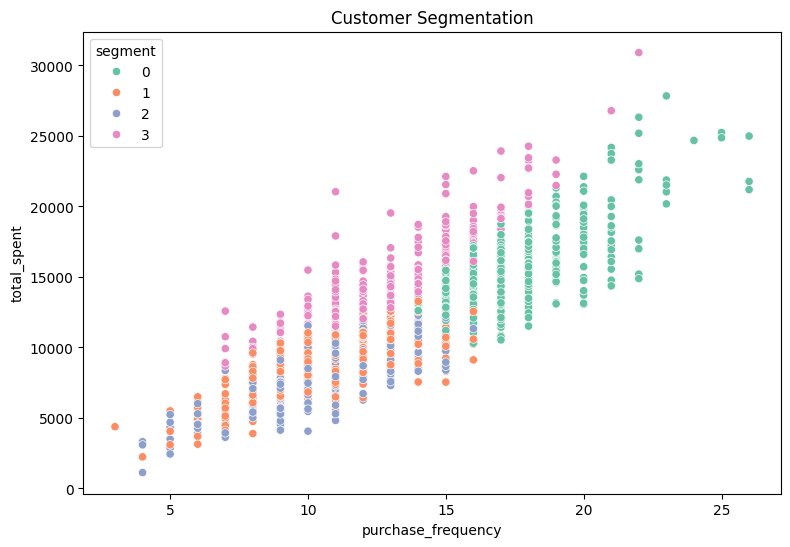

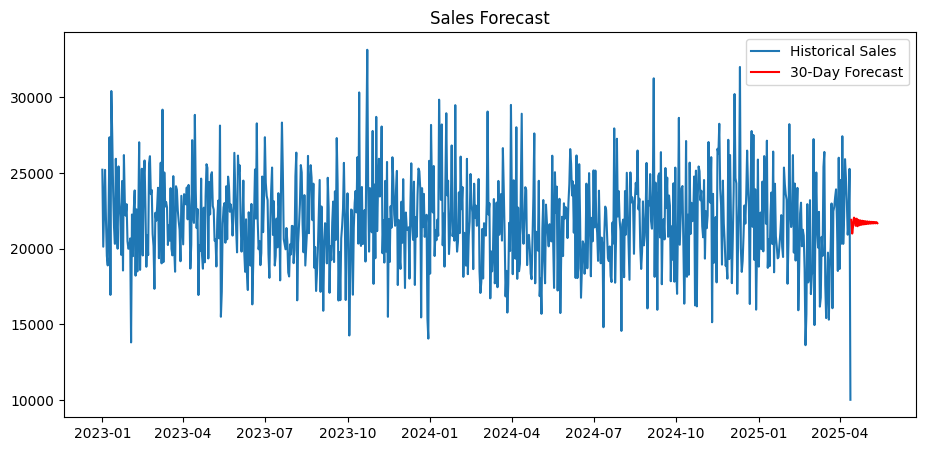

,discount_applied,final_value,Campaign
0,0,1.341041e+07,No Discount
1,1,4.768817e+06,Discount Applied


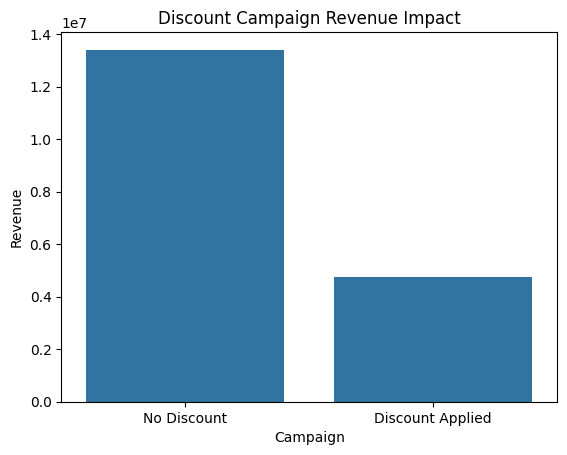

Segment-Level Insights:


,customer_id,purchase_frequency,total_spent,avg_order_value,discount_sensitivity
segment,,,,,
0,789.070295,17.360544,15369.679070,885.379518,0.335228
1,734.620137,11.082380,9281.830370,844.580203,0.220440
2,719.988131,11.005935,8821.881405,803.752423,0.474371
3,751.245614,13.305263,15340.581028,1159.215485,0.284260


Flask API ready:
/segments | /forecast | /roi


In [5]:

# STEP 3 → FULL ANALYTICS PIPELINE


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.arima.model import ARIMA
from flask import Flask

import warnings
warnings.filterwarnings("ignore")


# LOAD DATA

customers = pd.read_csv("customers.csv")
orders = pd.read_csv("orders.csv")
orders["order_date"] = pd.to_datetime(orders["order_date"])

# DATA CLEANING

orders.drop_duplicates(inplace=True)


# FEATURE ENGINEERING

customer_metrics = orders.groupby("customer_id").agg(
    purchase_frequency=("order_id", "count"),
    total_spent=("final_value", "sum"),
    avg_order_value=("final_value", "mean"),
    discount_sensitivity=("discount_applied", "mean")
).reset_index()

print("Customer Metrics Sample:")
display(customer_metrics.head())


# CUSTOMER SEGMENTATION (K-MEANS)

features = customer_metrics[
    ["purchase_frequency", "total_spent", "avg_order_value", "discount_sensitivity"]
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
customer_metrics["segment"] = kmeans.fit_predict(scaled_features)

print("Silhouette Score:",
      silhouette_score(scaled_features, customer_metrics["segment"]))

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=customer_metrics,
    x="purchase_frequency",
    y="total_spent",
    hue="segment",
    palette="Set2"
)
plt.title("Customer Segmentation")
plt.show()

# SALES FORECASTING (ARIMA)

daily_sales = orders.groupby(
    orders["order_date"].dt.date
)["final_value"].sum()

daily_sales.index = pd.to_datetime(daily_sales.index)

model = ARIMA(daily_sales, order=(5,1,2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(11,5))
plt.plot(daily_sales, label="Historical Sales")
plt.plot(forecast, label="30-Day Forecast", color="red")
plt.legend()
plt.title("Sales Forecast")
plt.show()


# DISCOUNT CAMPAIGN ROI

roi = orders.groupby("discount_applied")["final_value"].sum().reset_index()
roi["Campaign"] = roi["discount_applied"].map({
    0: "No Discount",
    1: "Discount Applied"
})

display(roi)

sns.barplot(x="Campaign", y="final_value", data=roi)
plt.title("Discount Campaign Revenue Impact")
plt.ylabel("Revenue")
plt.show()


# BUSINESS INSIGHTS SUMMARY

print("Segment-Level Insights:")
display(customer_metrics.groupby("segment").mean())


# FULL-STACK BACKEND (FLASK API)

app = Flask(__name__)

@app.route("/segments")
def segments_api():
    return customer_metrics.to_json(orient="records")

@app.route("/forecast")
def forecast_api():
    return forecast.to_json()

@app.route("/roi")
def roi_api():
    return roi.to_json(orient="records")

print("Flask API ready:")
print("/segments | /forecast | /roi")

# Uncomment below line ONLY when deploying
# app.run()
